<a href="https://colab.research.google.com/github/Eserhimas/Fundamentals/blob/main/LSTM_Time_Series_Prediction_exercises1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# https://medium.com/codex/time-series-prediction-using-lstm-in-python-19b1187f580f
# required libraries
#------------------------------------------------------------
import pandas as pd
import numpy as np
from pylab import rcParams

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import MinMaxScaler

# Modeling
from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

In [5]:
path = 'https://media.githubusercontent.com/media/Gendo90/Crypto-Historical-Prices/master/Ethereum/ETH_day.csv'

df = pd.read_csv(path)

# convert unix (in milliseconds) to UTC time
df['Date'] = pd.to_datetime(df['Date'])

In [6]:
df.head()

,Date,Symbol,Open,High,Low,Close,Volume ETH,Volume USD
0,2020-04-15,ETHUSD,158.61,158.61,158.61,158.61,0.00,0.00
1,2020-04-14,ETHUSD,156.97,162.15,155.74,158.61,18061.58,2872210.44
2,2020-04-13,ETHUSD,158.56,159.51,150.12,156.97,15698.32,2416728.28
3,2020-04-12,ETHUSD,158.66,165.37,155.21,158.56,12877.33,2082804.05
4,2020-04-11,ETHUSD,158.26,161.49,154.25,158.66,13761.72,2172914.57


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1438 entries, 0 to 1437
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        1438 non-null   datetime64[ns]
 1   Symbol      1438 non-null   object        
 2   Open        1438 non-null   float64       
 3   High        1438 non-null   float64       
 4   Low         1438 non-null   float64       
 5   Close       1438 non-null   float64       
 6   Volume ETH  1438 non-null   float64       
 7   Volume USD  1438 non-null   float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 90.0+ KB


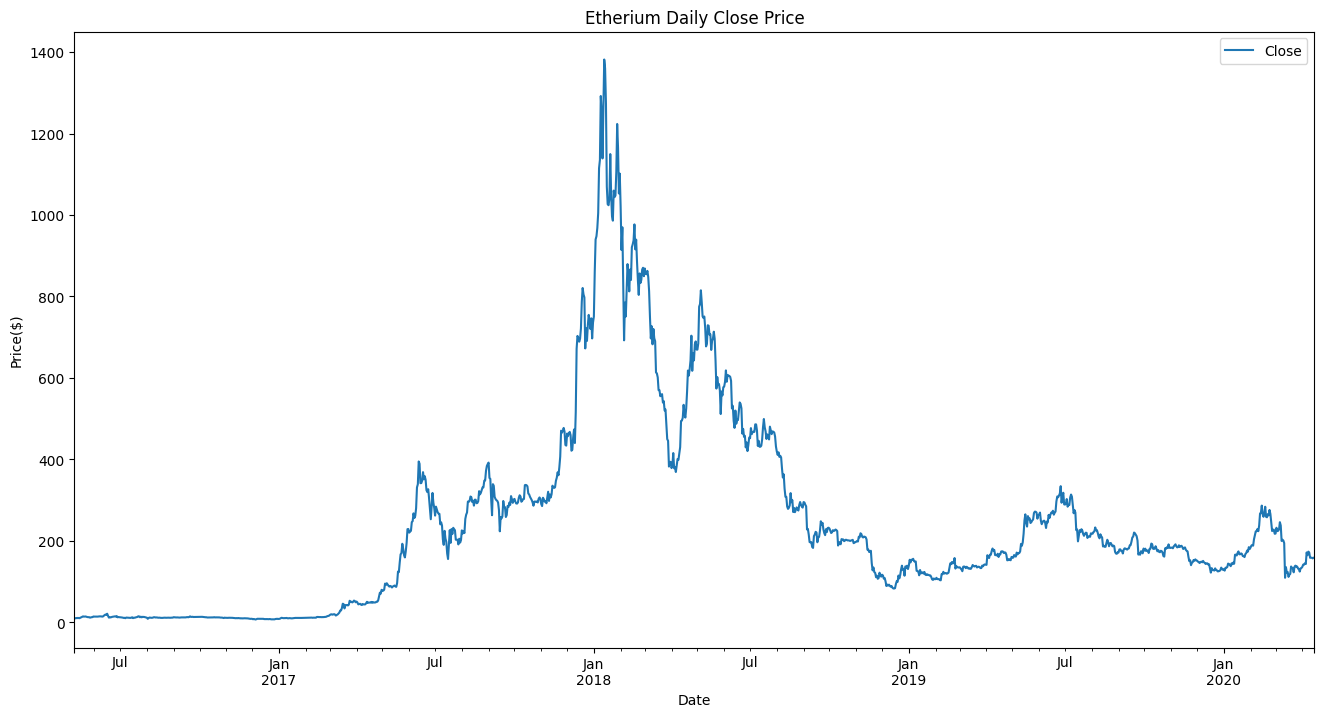

In [39]:
rcParams['figure.figsize'] = 16, 8

ax = df.plot(x='Date', y='Close')
ax.set_xlabel('Date')
ax.set_ylabel('Price($)')
ax.set_title('Etherium Daily Close Price')
plt.show()

In [17]:
scaler = MinMaxScaler()

close_pr = df.Close.values.reshape(-1,1)
scaled_close = scaler.fit_transform(close_pr)

In [21]:
scaled_close

array([[0.11042267],
       [0.11042267],
       [0.10923001],
       ...,
       [0.00266166],
       [0.00211624],
       [0.00233441]])

In [20]:
seq_length = 30

def split_into_sequence(data, seq_length):
  n_seq = len(data) - seq_length + 1
  return np.array([data[i: (i+seq_length)] for i in range(n_seq)])

In [22]:
def train_test_split(data, seq_len, train_frac):
  sequences = split_into_sequence(data, seq_length)
  n_train = int(sequences.shape[0] * train_frac)

  X_train = sequences[:n_train, :-1, :]
  y_train = sequences[:n_train, -1, :]
  X_test = sequences[n_train:, :-1, :]
  y_test = sequences[n_train:, -1, :]

  return X_train, y_train, X_test, y_test

In [23]:
X_train, y_train, X_test, y_test = train_test_split(scaled_close, seq_length, train_frac=0.9)

In [28]:
# LSTM

dropout = 0.2
window_size = seq_length - 1

model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True,
         input_shape=(window_size, X_train.shape[-1]))
)

model.add(Dropout(rate=dropout))

model.add(
    Bidirectional(LSTM((window_size*2), return_sequences=True))
)

model.add(Dropout(rate=dropout))

model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
)

model.add(Dense(units=1))
model.add(Activation('linear'))

In [29]:
# model training

batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=16,
    shuffle=False,
    validation_split=0.2
)

Epoch 1/10
64/64 [==============================] - 21s 128ms/step - loss: 0.0106 - val_loss: 0.0079
Epoch 2/10
64/64 [==============================] - 5s 76ms/step - loss: 0.0103 - val_loss: 0.0146
Epoch 3/10
64/64 [==============================] - 5s 77ms/step - loss: 0.0139 - val_loss: 0.0142
Epoch 4/10
64/64 [==============================] - 4s 70ms/step - loss: 0.0264 - val_loss: 0.0253
Epoch 5/10
64/64 [==============================] - 5s 86ms/step - loss: 0.0213 - val_loss: 0.0393
Epoch 6/10
64/64 [==============================] - 4s 67ms/step - loss: 0.0137 - val_loss: 0.0125
Epoch 7/10
64/64 [==============================] - 4s 66ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 8/10
64/64 [==============================] - 5s 85ms/step - loss: 0.0029 - val_loss: 0.0062
Epoch 9/10
64/64 [==============================] - 4s 68ms/step - loss: 0.0039 - val_loss: 6.4475e-04
Epoch 10/10
64/64 [==============================] - 5s 77ms/step - loss: 0.0018 - val_loss: 0.0027


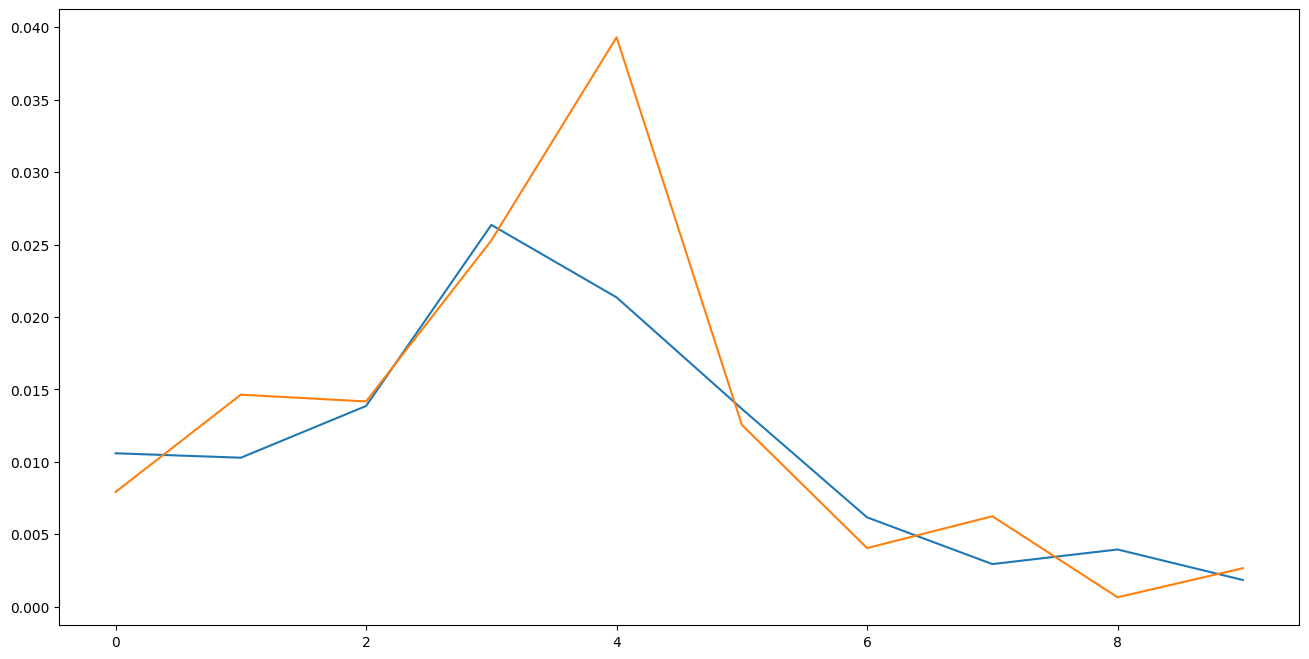

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

5/5 [==============================] - 4s 20ms/step


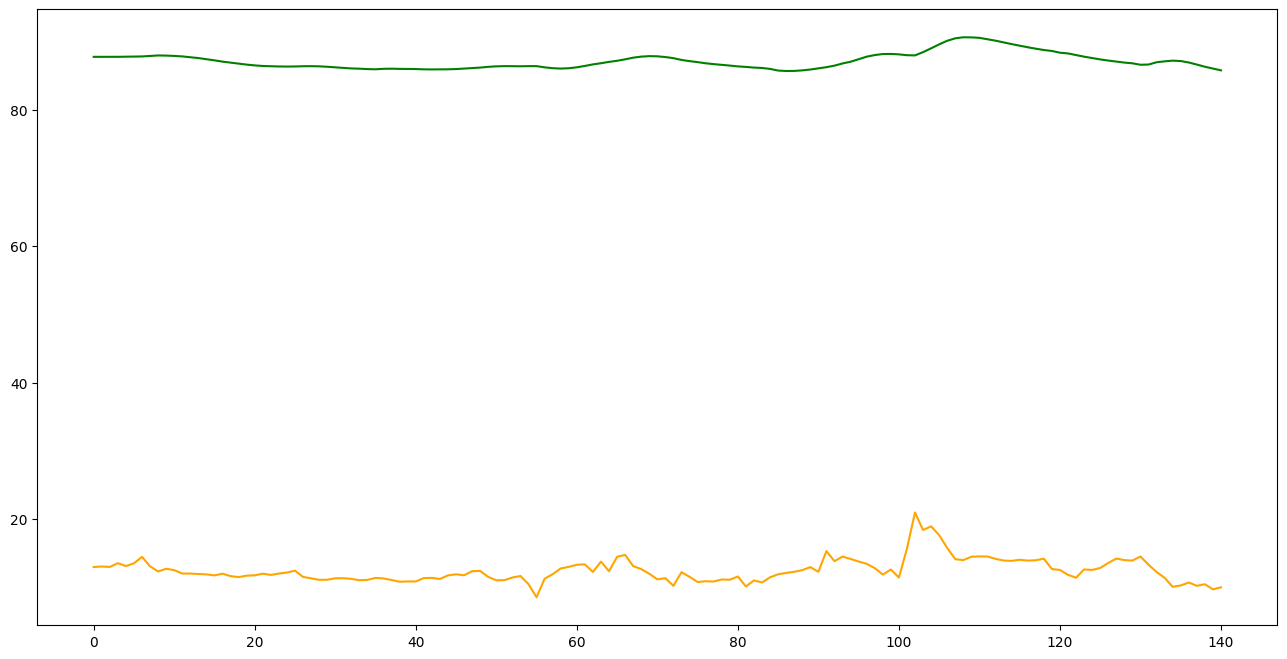

In [33]:
y_pred = model.predict(X_test)

y_test_org = scaler.inverse_transform(y_test)
y_pred_org = scaler.inverse_transform(y_pred)

plt.plot(y_test_org, label='Actual Price', color='orange')
plt.plot(y_pred_org, label='Predicted Price', color='green')
plt.show()

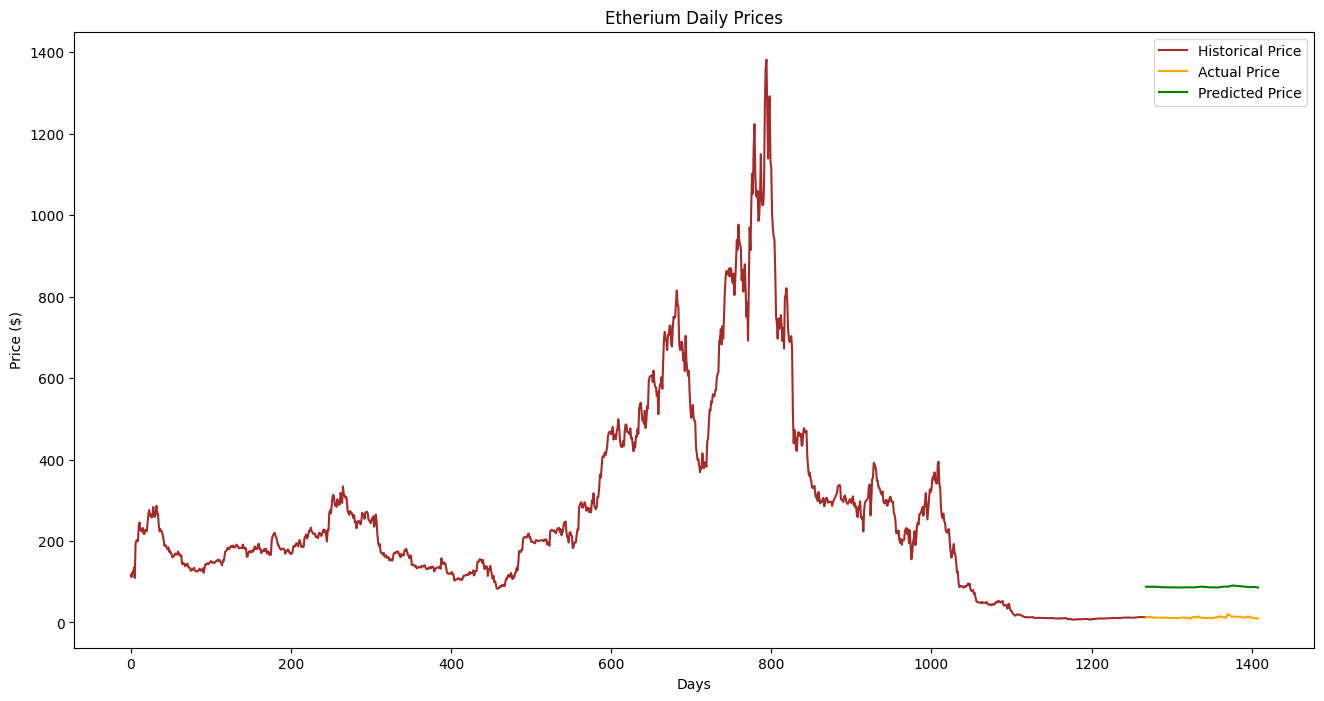

In [40]:
# plot for whole range of data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_org)), y_test_org, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_org)), y_pred_org, color='green', label='Predicted Price')

plt.title('Etherium Daily Prices')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend()
plt.show();